## Loan Approved or Denied - Random Forest
**=======================================================**

### Data Preparation

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 1500)

import warnings
warnings.filterwarnings('ignore')

#Extend cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
X_train = pd.read_csv('/Users/thienla/Desktop/Portfolio/Machine Learning/Module 4/Lab 5/SBA_loans_train.csv')
X_test  = pd.read_csv('/Users/thienla/Desktop/Portfolio/Machine Learning/Module 4/Lab 5/SBA_loans_test.csv')
orig_columns = list(X_train.columns)

In [3]:
print(orig_columns)

['City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv', 'Defaulted']


In [4]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (337186, 20)
Test shape: (112396, 20)


In [5]:
values_to_fill = {}
for col in X_train.drop(columns=['Defaulted']).columns:
    if X_train[col].dtype == 'object':
        values_to_fill[col] = "Missing"
    else:
        values_to_fill[col] = 0

X_train.fillna(value=values_to_fill,inplace=True)
X_test.fillna(value=values_to_fill, inplace=True)

#### Variables Encoding

In [6]:
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from copy import deepcopy

label_col = 'Defaulted'
orig_categorical_columns = ["City", "State", "Bank", "BankState", "RevLineCr", "LowDoc"]
cat_encoders = {}

# Target Encoding
target_encoder = ce.TargetEncoder(cols=orig_categorical_columns, min_samples_leaf=20, smoothing=10)
target_encoder.fit(X_train[orig_categorical_columns],X_train[label_col])
X_train_target_enc = target_encoder.transform(X_train[orig_categorical_columns])
X_test_target_enc = target_encoder.transform(X_test[orig_categorical_columns])

# Weight of Evidence Encoding
woe_encoder = ce.WOEEncoder(cols=orig_categorical_columns)
woe_encoder.fit(X_train[orig_categorical_columns],X_train[label_col])
X_train_woe_enc = woe_encoder.transform(X_train[orig_categorical_columns])
X_test_woe_enc = woe_encoder.transform(X_test[orig_categorical_columns])

te_columns = []
woe_columns = []
for col in orig_categorical_columns:
    X_train[col+"_te"] = X_train_target_enc[col]
    X_test[col+"_te"] = X_test_target_enc[col]
    te_columns.append(col+"_te")
    
    X_train[col+"_woe"] = X_train_woe_enc[col]
    X_test[col+"_woe"] = X_test_woe_enc[col]
    woe_columns.append(col+"_woe")

cat_encoders[("orig_categorical_columns","te")] = [deepcopy(target_encoder),"te"]
cat_encoders[("orig_categorical_columns","woe")] = [deepcopy(woe_encoder),"woe"]

In [7]:
cat_encoders

{('orig_categorical_columns',
  'te'): [TargetEncoder(cols=['City', 'State', 'Bank', 'BankState', 'RevLineCr',
                      'LowDoc']), 'te'],
 ('orig_categorical_columns',
  'woe'): [WOEEncoder(cols=['City', 'State', 'Bank', 'BankState', 'RevLineCr', 'LowDoc']), 'woe']}

In [8]:
X_train.head()

,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,Defaulted,City_te,City_woe,State_te,State_woe,Bank_te,Bank_woe,BankState_te,BankState_woe,RevLineCr_te,RevLineCr_woe,LowDoc_te,LowDoc_woe
0,Huntsville,AL,35811,"BUSINESS LOAN CENTER, LLC",FL,621310,73,1,2.0,2,1,0,1,N,N,25000.0,0.0,25000.0,21250.0,1,0.283212,1.107415,0.167744,-0.050917,0.308181,0.741374,0.158105,-0.122172,0.146342,-0.214300,0.186457,0.076065
1,SCOTTSDALE,AZ,85254,WELLS FARGO BANK NATL ASSOC,CA,0,84,3,2.0,0,0,0,0,N,N,52000.0,0.0,52000.0,46800.0,1,0.191919,0.118312,0.200634,0.167471,0.138341,-0.279641,0.221678,0.293405,0.146342,-0.214300,0.186457,0.076065
2,BANGOR,ME,4401,BANGOR SAVINGS BANK,ME,323110,84,9,1.0,0,0,1,1,0,Y,150000.0,0.0,150000.0,127500.0,0,0.125985,-0.336038,0.096586,-0.682359,0.062502,-1.049319,0.076696,-0.930088,0.149252,-0.191171,0.090740,-0.755151
3,AVONDALE,AZ,85323,NATIONAL BANK OF ARIZONA,AZ,722110,27,20,1.0,0,20,10625,2,Y,N,186959.0,0.0,100000.0,50000.0,1,0.351182,1.063740,0.200634,0.167471,0.059406,-1.162305,0.068197,-1.056343,0.253136,0.467327,0.186457,0.076065
4,HAMMOND,LA,70403,"BIZCAPITAL BIDCO II, LLC",LA,0,60,1,1.0,0,0,1,1,0,Y,50000.0,0.0,50000.0,40000.0,0,0.275805,0.622485,0.179574,0.031247,0.362410,1.072323,0.101741,-0.624053,0.149252,-0.191171,0.090740,-0.755151


### Random Forest Models

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

best_f1 = 0
best_params = {}
best_model = None
label_col = 'Defaulted'

Y_tr = X_train[label_col].copy()
X_tr = X_train.drop(columns=orig_categorical_columns).drop(columns=label_col).copy()

Y_tst = X_test[label_col].copy()
X_tst = X_test.drop(columns=orig_categorical_columns).drop(columns=label_col).copy()

In [10]:
# Perform split of the Training dataset to Train and Validation datasets. Use Validation dataset to find best performing model.
X_tr, X_valid, Y_tr, Y_valid = train_test_split(X_tr, Y_tr, test_size=0.2, random_state=42)

In [11]:
X_tr.head()

,Zip,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,City_te,City_woe,State_te,State_woe,Bank_te,Bank_woe,BankState_te,BankState_woe,RevLineCr_te,RevLineCr_woe,LowDoc_te,LowDoc_woe
315787,43055,624410,84,8,1.0,0,8,0,1,25000.0,0.0,25000.0,12500.0,0.190024,0.108886,0.162080,-0.093177,0.413289,1.198946,0.382280,1.069458,0.146342,-0.2143,0.186457,0.076065
77896,55418,0,84,2,1.0,0,0,1,0,40000.0,0.0,40000.0,32000.0,0.116101,-0.472486,0.115061,-0.489985,0.166975,0.102328,0.075003,-0.961358,0.146342,-0.2143,0.090740,-0.755151
219153,3289,313311,119,7,1.0,0,0,1,0,64000.0,0.0,64000.0,51200.0,0.150340,0.450635,0.106169,-0.579384,0.178571,0.045170,0.059538,-1.204155,0.146342,-0.2143,0.186457,0.076065
88526,36701,621111,84,3,1.0,0,0,1,2,125000.0,0.0,125000.0,62500.0,0.252687,1.836929,0.167744,-0.050917,0.413289,1.198946,0.382280,1.069458,0.146342,-0.2143,0.186457,0.076065
183654,78577,541519,54,2,1.0,0,0,1,1,60285.0,0.0,60285.0,51242.0,0.232732,0.484537,0.192113,0.113060,0.128049,-0.329523,0.141874,-0.250239,0.146342,-0.2143,0.186457,0.076065


#### Optimal Hyper-Parameters

Depending on quality of computer, increase or decrease the speed of model training by specifying n_jobs parameter.

In [ ]:
best_f1 = 0
best_params = {}
best_model = None
label_col = 'Defaulted'


for n_estimators in [50, 100, 200]:
    for max_depth in [5,7,10]:
        for max_features in ["sqrt", "log2", 5]:
            for max_samples in [0.2, 0.4, 0.6]:
                rfc = RandomForestClassifier(n_jobs=7,
                                             random_state=0, 
                                             bootstrap=True,
                                             n_estimators=n_estimators,
                                             max_depth=max_depth,
                                             max_features=max_features,
                                             max_samples=max_samples)

                rfc.fit(X_tr, Y_tr)
                y_valid_pred = rfc.predict(X_valid)
                f1 = f1_score(Y_valid, y_valid_pred, average='weighted')
                if f1>best_f1:
                    best_f1 = f1
                    best_params["n_estimators"] = n_estimators
                    best_params["max_depth"] = max_depth
                    best_params["max_features"] = max_features
                    best_params["max_samples"] = max_samples
                    print("Better Model found. Trained Random Forest with (n_estimators, max_depth, max_features,max_samples):(", \
                                    n_estimators, max_depth,max_features,max_samples,")")

Better Model found. Trained Decision Tree with (n_estimators, max_depth, max_features,max_samples):( 50 5 sqrt 0.2 )
F1 for Validation: 0.8774484584501934
Better Model found. Trained Decision Tree with (n_estimators, max_depth, max_features,max_samples):( 50 5 sqrt 0.4 )
F1 for Validation: 0.8804712692135904
Better Model found. Trained Decision Tree with (n_estimators, max_depth, max_features,max_samples):( 50 7 sqrt 0.2 )
F1 for Validation: 0.8985631730088207
Better Model found. Trained Decision Tree with (n_estimators, max_depth, max_features,max_samples):( 50 7 sqrt 0.4 )
F1 for Validation: 0.9057662981539798
Better Model found. Trained Decision Tree with (n_estimators, max_depth, max_features,max_samples):( 50 10 sqrt 0.2 )
F1 for Validation: 0.919848942011958
Better Model found. Trained Decision Tree with (n_estimators, max_depth, max_features,max_samples):( 50 10 sqrt 0.4 )
F1 for Validation: 0.9214827529255847
Better Model found. Trained Decision Tree with (n_estimators, max_dep

In [18]:
print("F1 for Validation:", f1)

F1 for Validation: 0.9133688907237967


In [19]:
print("Best params:", best_params)

Best params: {'n_estimators': 100, 'max_depth': 10, 'max_features': 'sqrt', 'max_samples': 0.6}


#### Best Parameters Random Forest Model 

In [20]:
from sklearn.metrics import confusion_matrix
Y_tr = X_train[label_col].copy()
X_tr = X_train.drop(columns=orig_categorical_columns).drop(columns=label_col).copy()

best_model = RandomForestClassifier(n_jobs=4,
                                    random_state=0,
                                    bootstrap=True,
                                    n_estimators=best_params["n_estimators"],
                                    max_depth=best_params["max_depth"],
                                    max_features=best_params["max_features"],
                                    max_samples=best_params["max_samples"])

best_model.fit(X_tr, Y_tr)

RandomForestClassifier(max_depth=10, max_samples=0.6, n_jobs=4, random_state=0)

Reporting metrics

In [15]:
y_tst_pred = best_model.predict(X_tst)
y_tr_pred = best_model.predict(X_tr)
print("Trained Decision Tree with parameters:")
print(best_params)
print("F1 for Train:", f1_score(Y_tr, y_tr_pred, average='weighted'))
f1 = f1_score(Y_tst, y_tst_pred, average='weighted')
print("F1 for Test:", f1)
print("Test set confusion matrix:")
print(confusion_matrix(Y_tst, y_tst_pred))

Trained Decision Tree with parameters:
{'n_estimators': 100, 'max_depth': 10, 'max_features': 'sqrt', 'max_samples': 0.6}
F1 for Train: 0.9256760952498487
F1 for Test: 0.9133688907237967
Test set confusion matrix:
[[90804  1885]
 [ 7259 12448]]


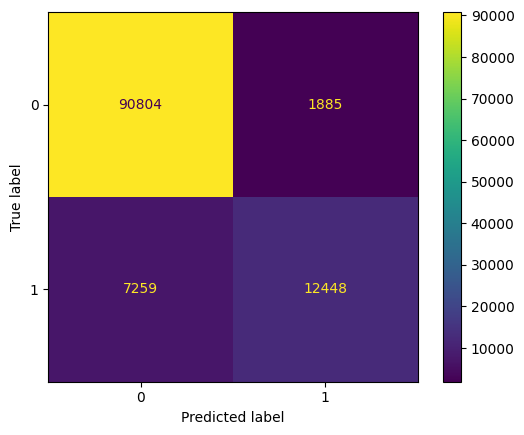

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_tst, y_tst_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_model.classes_)
disp.plot()
plt.show()

### Feature Importances

Calculate best model feature importances using permutation method

Produce visualization of the best model feature importances

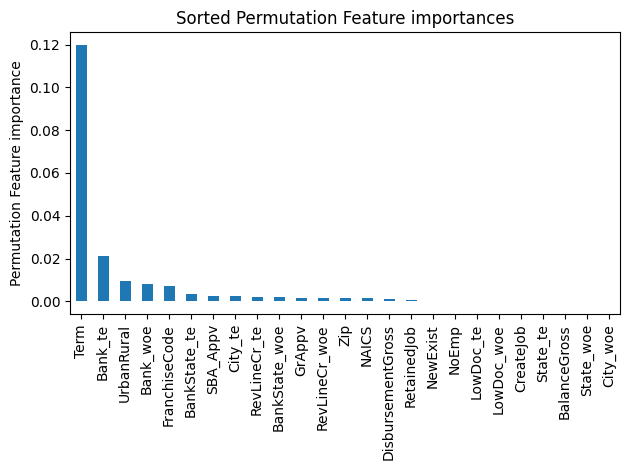

In [17]:
from sklearn.inspection import permutation_importance
import pandas as pd
result = permutation_importance(
    best_model, X_tst, Y_tst, n_repeats=10, random_state=42, n_jobs=8
)

tree_importances = pd.Series(result.importances_mean, index=X_tst.columns)

feature_names = X_tst.columns
tree_importances = tree_importances.sort_values(ascending=False)

fig, ax = plt.subplots()
tree_importances.plot.bar(ax=ax)
ax.set_title("Sorted Permutation Feature importances")
ax.set_ylabel("Permutation Feature importance")
fig.tight_layout()